<a href="https://colab.research.google.com/github/rishabhshah13/Adversarial_Patch_XAI590/blob/main/Rishabh_Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #00
### Description
### Rishabh Shah

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/rishabhshah13/Adversarial_Patch_XAI590.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Rishabh_Adversarial_Attacks.ipnyb'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'Adversarial_Patch_XAI590'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 3.41 MiB | 7.39 MiB/s, done.
Resolving deltas: 100% (14/14), done.
[Errno 2] No such file or directory: 'Duke-AI-XAI/Rishabh_Adversarial_Attacks.ipnyb'
/content
Adversarial_Patch_XAI590/


In [2]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [3]:
# !pip install torch numpy scipy torch torchvision seaborn matplotlib tqdm ipywidgets tabulate

In [4]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial10"
# CHECKPOINT_PATH = '/content/Adversarial_Patch_XAI590/patches'
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-4-b8bcb60b98e7>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [5]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


In [6]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.3MB/s]


In [7]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def eval_model(dataset_loader, img_func=None):
    """
    Evaluates a pretrained model's performance on a given dataset using Top-1 and Top-5 accuracy.

    Args:
        dataset_loader (torch.utils.data.DataLoader): A DataLoader object that provides batches of images and labels.
        img_func (callable, optional): A function that applies transformations or perturbations to the images.
                                       It takes two arguments: images and labels, and returns modified images.
                                       If None, no transformation is applied.

    Returns:
        acc (float): Top-1 accuracy, calculated as the fraction of images for which the highest probability prediction matches the ground truth label.
        top5 (float): Top-5 accuracy, calculated as the fraction of images for which the correct label is among the top 5 predicted probabilities.

    Prints:
        Top-1 error: Percentage of samples where the top prediction did not match the ground truth.
        Top-5 error: Percentage of samples where the ground truth label was not in the top 5 predictions.
    """
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [9]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


In [10]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    """
    Displays an image, the true label, top-K predicted labels with their probabilities, and optionally adversarial images and noise.

    Args:
        img (torch.Tensor or np.ndarray): The input image to display. If a torch.Tensor, it will be converted to a numpy array.
        label (int): The true label index of the input image.
        pred (torch.Tensor): The predicted probabilities for all classes. It is used to extract top-K predictions.
        K (int, optional): Number of top predictions to display in the bar plot (default is 5).
        adv_img (torch.Tensor or np.ndarray, optional): The adversarial version of the input image, if available, to be displayed alongside the original image.
        noise (torch.Tensor or np.ndarray, optional): The perturbation noise applied to create the adversarial image, to be visualized if provided.

    Returns:
        None. Displays a plot showing the original image, predicted labels, and optionally the adversarial image and noise.
    """
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

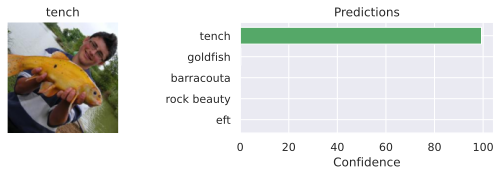

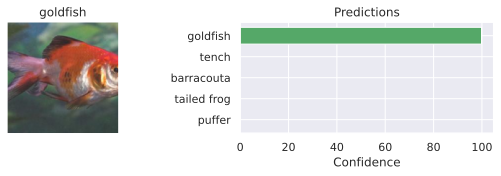

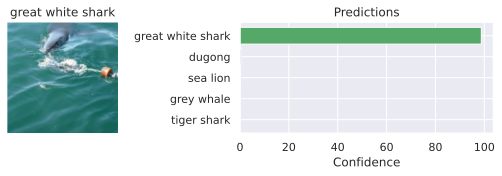

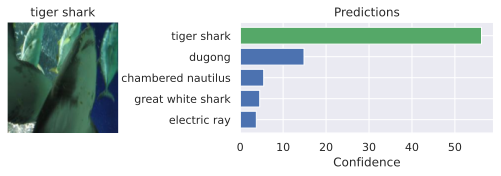

In [11]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [12]:
# def place_patch(img, patch):
#     for i in range(img.shape[0]):
#         h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
#         w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
#         img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
#     return img


import torch
import numpy as np
import torch.nn.functional as F

def resize_patch(patch, target_size):
    """
    Resizes the input patch to the specified target size using bilinear interpolation.

    Args:
        patch (torch.Tensor): The input patch, typically a 3D tensor (C, H, W) representing the image patch.
        target_size (tuple): The desired target size as (height, width) to which the patch will be resized.

    Returns:
        torch.Tensor: The resized patch with the specified target size.
    """
    # Resize the patch to the target size (256x256) if needed
    return F.interpolate(patch.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False).squeeze(0)

def place_patch(img, patch):
    """Places a patch onto an image at a random location.

    Args:
        img (torch.Tensor): The image tensor with shape (batch_size, channels, height, width).
        patch (torch.Tensor): The patch tensor with shape (channels, patch_height, patch_width).

    Returns:
        torch.Tensor: The image tensor with the placed patch.

    Raises:
        ValueError: If the patch size is larger than the image dimensions or if the patch and image have different number of channels.
    """
    # Get image dimensions
    batch_size, img_channels, img_height, img_width = img.shape

    # Define a constant patch size
    patch_size = 64  # Adjust this size if needed

    # Ensure the patch size is feasible
    if img_height < patch_size or img_width < patch_size:
        raise ValueError(f"Patch size {patch_size}x{patch_size} is larger than image dimensions {img_height}x{img_width}.")

    # Resize patch to the constant patch size
    patch_resized = resize_patch(patch, (patch_size, patch_size))

    # Ensure resized patch has the same number of channels as image
    if patch_resized.shape[0] != img_channels:
        raise ValueError(f"Patch has {patch_resized.shape[0]} channels, but image has {img_channels} channels.")

    for i in range(batch_size):
        # Calculate random offsets ensuring the patch fits inside the image
        h_offset = np.random.randint(0, img_height - patch_size + 1)
        w_offset = np.random.randint(0, img_width - patch_size + 1)

        # Place the resized patch into the image
        img[i, :, h_offset:h_offset + patch_size, w_offset:w_offset + patch_size] = patch_resized

    return img


In [13]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    """Maps patch values from [-infty,infty] to ImageNet min and max.

    Args:
        patch (torch.Tensor): The patch tensor.

    Returns:
        torch.Tensor: The patch tensor with values mapped to ImageNet range.
    """
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [14]:
def eval_patch(model, patch, val_loader, target_class):
    """Evaluates the effectiveness of a patch on a target class.

    Args:
        model (torch.nn.Module): The model to evaluate.
        patch (torch.Tensor): The patch tensor.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
        target_class (int): The target class to evaluate against.

    Returns:
        tuple: A tuple containing the accuracy and top-5 accuracy of the patch.

    """
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [15]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    """Trains a patch to fool a model into classifying images as a target class.

    Args:
        model (torch.nn.Module): The model to attack.
        target_class (int): The target class to fool the model into classifying.
        patch_size (int or tuple, optional): The size of the patch. Defaults to 64.
        num_epochs (int, optional): The number of training epochs. Defaults to 5.

    Returns:
        tuple: A tuple containing the trained patch and a dictionary with the final accuracy and top-5 accuracy on the validation set.
    """

    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [16]:
CHECKPOINT_PATH

'saved_models/tutorial10'

In [17]:
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

json_results

{'toaster': {'32': [0.4888888895511627, 0.7202202081680298],
  '48': [0.9047547578811646, 0.9812312126159668],
  '64': [0.9858358502388, 0.9993493556976318]},
 'goldfish': {'32': [0.6953453421592712, 0.8631131052970886],
  '48': [0.9352852702140808, 0.9906907081604004],
  '64': [0.9834334254264832, 0.9995495676994324]},
 'school bus': {'32': [0.7879379391670227, 0.9163663387298584],
  '48': [0.939489483833313, 0.9914914965629578],
  '64': [0.9822322130203247, 0.9989489316940308]},
 'lipstick': {'32': [0.43363362550735474, 0.7009509801864624],
  '48': [0.860510528087616, 0.968618631362915],
  '64': [0.9641141295433044, 0.9972972869873047]},
 'pineapple': {'32': [0.7973973751068115, 0.9223223328590393],
  '48': [0.9448448419570923, 0.9925925731658936],
  '64': [0.9872372150421143, 0.9995995759963989]}}

In [18]:
# Load evaluation results of the pretrained patches
PATCH_PATH = '/content/Adversarial_Patch_XAI590/patches'

json_results_file = os.path.join(PATCH_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [19]:
PATCH_PATH = '/content/Adversarial_Patch_XAI590/patches'
def get_patches(class_names, patch_sizes):
    """Loads or trains patches for each class and patch size.

    Args:
        class_names (list): List of class names to train patches for.
        patch_sizes (list): List of patch sizes to train.

    Returns:
        dict: A dictionary containing patches and evaluation results for each class and patch size.
    """
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(PATCH_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)
            results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [20]:
class_names = ['toaster', 'goldfish', 'school bus']
# patch_sizes = [32, 48, 64]
patch_sizes = [32, 128, 512]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

<ipython-input-19-f459aba166f5>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(file_name)


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

In [21]:
json_results

{'toaster': {'32': [0.9518518447875977, 0.9938939213752747],
  '128': [0.8977477550506592, 0.9799799919128418],
  '512': [0.9055054783821106, 0.9816316366195679]},
 'goldfish': {'32': [0.9611111283302307, 0.9971972107887268],
  '128': [0.0005005004932172596, 0.0054054055362939835],
  '512': [0.34044045209884644, 0.5869869589805603]},
 'school bus': {'32': [0.9438939094543457, 0.9927427172660828],
  '128': [0.7029529809951782, 0.8513013124465942],
  '512': [0.8218218088150024, 0.935935914516449]}}

Before looking at the quantitative results, we can actually visualize the patches.

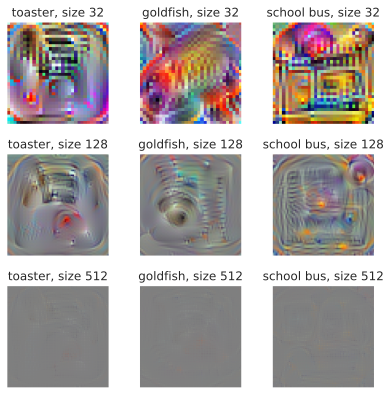

In [22]:
def show_patches():
    """Visualizes the trained patches for different classes and sizes.

    Plots a grid of images, where each row represents a patch size and each column represents a class.
    The title of each subplot shows the class name and patch size.
    """
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

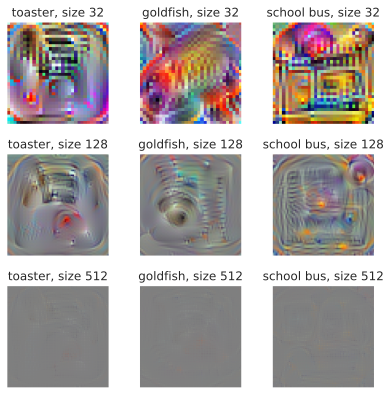

In [23]:
import matplotlib.pyplot as plt
import torch
import os

def show_patches_enlarged():
    """Visualizes the trained patches for different classes and sizes.

    Plots a grid of images, where each row represents a patch size and each column represents a class.
    The title of each subplot shows the class name and patch size.
    Saves the plot to a folder named 'patch_saved'.
    """
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*4.2, len(patch_sizes)*4.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Create the 'patch_saved' folder if it doesn't exist
    os.makedirs('patch_saved', exist_ok=True)
    plt.savefig('patch_saved/patches.jpg')
    plt.show()

show_patches()

In [24]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [25]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [26]:
show_table(top_1=True)

Class name,Patch size 32x32,Patch size 128x128,Patch size 512x512
toaster,95.41%,90.31%,90.28%
goldfish,96.10%,0.02%,33.97%
school bus,93.96%,69.92%,82.16%


In [27]:
show_table(top_1=False)

Class name,Patch size 32x32,Patch size 128x128,Patch size 512x512
toaster,99.49%,97.96%,98.17%
goldfish,99.65%,0.54%,58.55%
school bus,99.23%,85.22%,93.45%


In [28]:
# exmp_batch

In [29]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

## Creative

This code snippet extracts individual color channels from a patch and creates separate images for each channel.

It creates three new tensors (red_img, green_img, blue_img) initialized with zeros, the same size as the patch.
Then, it copies the corresponding channel from a different patch ('goldfish' with size 128) to the respective channel of the new images.



In [40]:
red_img = torch.zeros_like(patch_dict['goldfish'][32]['patch'])
red_img[1] = patch_dict['goldfish'][32]['patch'][0]

green_img = torch.zeros_like(patch_dict['goldfish'][32]['patch'])
green_img[1] = patch_dict['goldfish'][32]['patch'][1]

blue_img = torch.zeros_like(patch_dict['goldfish'][32]['patch'])
blue_img[1] = patch_dict['goldfish'][32]['patch'][2]

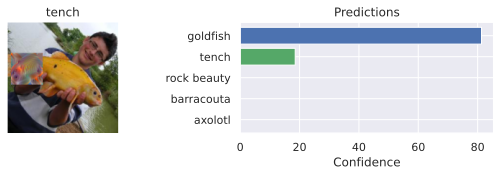

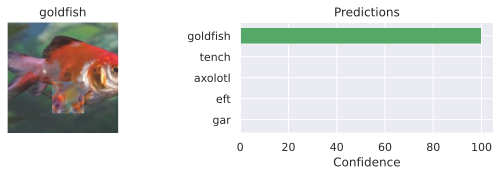

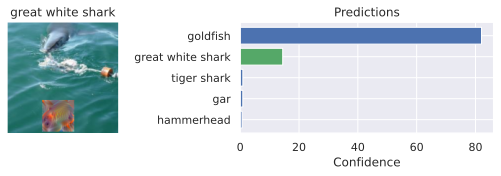

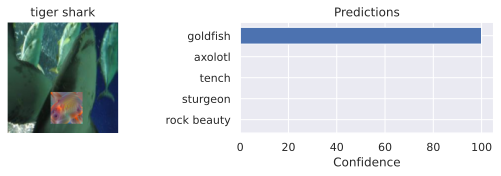

In [42]:
perform_patch_attack(patch_dict['goldfish'][32]['patch'])

### Individual Color Patches vs Combined RGB Patch

While individual color channel extraction (Red, Green, and Blue) helps us isolate specific information from an image, **individual color patches do not work as effectively** as the combined RGB patch for most tasks.

#### Why Individual Color Patches Struggle:
1. **Loss of Color Interaction**: Each channel (Red, Green, Blue) provides incomplete information about the image. Many objects or patterns are only distinguishable when the channels are combined.
2. **Lack of Detail**: Important details like edges, shapes, and textures are often formed through the interaction of all three channels. Isolating one channel reduces the amount of visible detail.
3. **Perception**: Our visual system relies on the combined RGB input to perceive colors accurately. Individual channels show grayscale versions of the Red, Green, or Blue intensities, which don't convey the full visual picture.


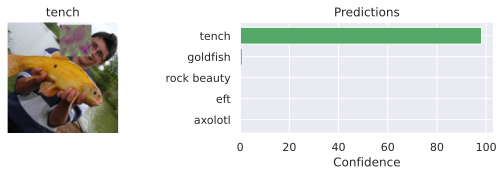

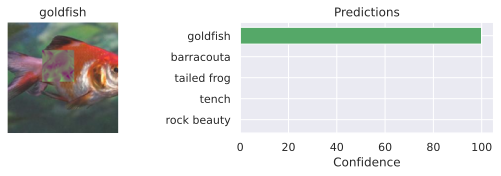

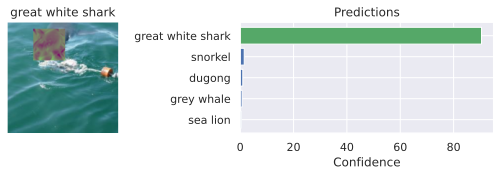

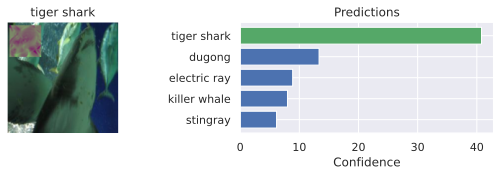

In [43]:
perform_patch_attack(blue_img)

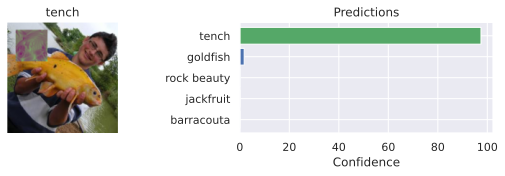

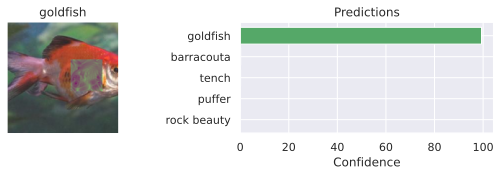

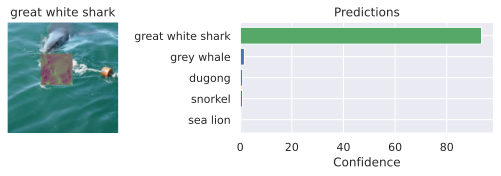

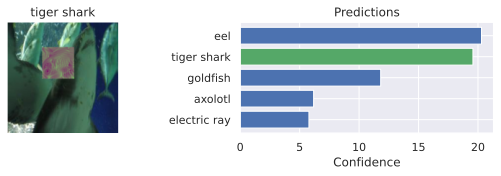

In [44]:
perform_patch_attack(green_img)

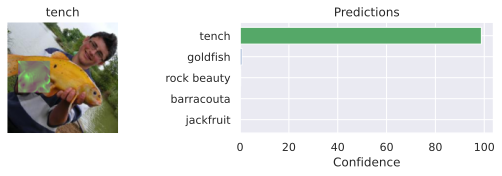

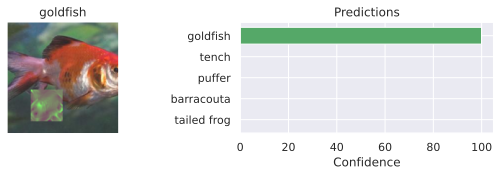

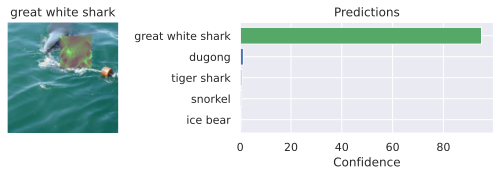

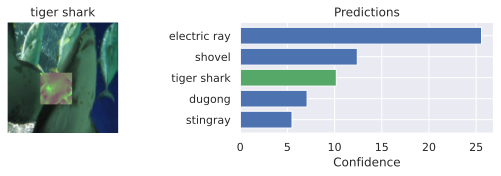

In [45]:
perform_patch_attack(red_img)

# Reference:


1.   https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb#scrollTo=EvWZTPmL1sGP
2.   Perplexity AI